# MobileNet V2

In this notebook, the classification task is trained with a deep neural network called MobileNet V2 (https://arxiv.org/abs/1801.04381v4). I have chosen this network for the following reasons:

- It is lightweight and does not have a huge number of parameters
- Others in the Kaggle community have used it to train for this task.
- There is a pretrained model available in pytorch

In [1]:
from PIL import Image
from torchvision import transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
import os
from pathlib import Path
import torch
import matplotlib.pyplot as plt

data_dir = "../data/train"
labels = ['fresh','blackspot','canker','grenning']

## Transform dataset

Before the input data is applied to the network, it needs to be preprocessed. Therefore, the pytorch transform function is used with the following operations:

- As discussed in the data_analysis notebook, the images need to be resized to all have the same resolution. Based on the scatter plot, a pixel size of 256 x 256 is used.
- On the following page (https://pytorch.org/hub/pytorch_vision_mobilenet_v2/), it is suggested to normalize the images. This is required in order to start with a pretrained model.
- To prevent overfitting across epochs, the data is randomly flipped and rotated.
- Moreover, GaussianBlur and ColorJitter is applied to prevent overfitting. However, these two operations should be applied with caution -> Not in use in final version

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Resize((256, 256)),  # Resize images
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    transforms.RandomRotation(360),  # Randomly rotate images by up to 360 degrees
    #transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1,5)),
    #transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize images
])

## Load dataset

We load that dataset into a class called OrangeDiseaseDataset that contains all images and corresponding labels. 

In [3]:
class OrangeDiseaseDataset(Dataset):
    def __init__(self, data_dir, labels, transform=None):
        self.data_dir = data_dir
        self.labels = labels
        self.transform = transform
        self.data = []
        self._load_images()

    def _load_images(self):
        for label in labels:
            label_dir = os.path.join(self.data_dir,label)
            [self.data.append((img_path, label)) for ext in ['*.jpg','*.png'] for img_path in Path(label_dir).rglob(ext)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label_idx = self.labels.index(label)
        return image, label_idx

# Create dataset
dataset = OrangeDiseaseDataset(data_dir, labels, transform=transform)

print(f"{len(dataset)} images are loaded")

991 images are loaded


## Split dataset into training and validation

We use an 80/20 split to seperate the data into training and validation. 

The batch size is chosen to be 64, which is a common choice for small to medium size models and datasets. Compared to a batch size of 32, less noise behaviour of training and validation loss was observed.

In [4]:
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

## Load Model

The MobileNet V2 model is loaded with pretrained labels. This can massively reduce time to convergence. Only the final fully connected layer of the network is adapted to fit the number of outputs/categories. 

Finally the model is loaded into the GPU if available.

In [5]:
# Load MobileNet v2 model
model = models.mobilenet_v2(pretrained=True)

# Modify the final layer to match the number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(labels))

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


# Set up optimizer

Loss function: Cross entropy loss is used as it is the most common choise for classification taks. 

Optimizer: The Adam (Adaptive Moment Estimation) is used with default parameter to compute the learning rate. It is a popular choice as it often works well out of the box and combines advantages of both momentum and adaptive learning rates. 

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## Train the model

In this section the model is trained on the dataset. 

For each epoch the model is trained, the train and validation losses are calculated and the resulting model is saved to a file. 

In [7]:
# Training the model
num_epochs = 10
train_losses = []
validation_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
    
    validation_loss = running_loss / len(test_loader.dataset)
    validation_losses.append(validation_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Validation loss: {validation_loss:.3f}")
    
    # Save the model
    torch.save(model.state_dict(), f'../models/mobilenet_v2_epoch_{epoch}.pth')

Epoch 1/10.. Train loss: 0.230.. Validation loss: 0.166
Epoch 2/10.. Train loss: 0.085.. Validation loss: 0.082
Epoch 3/10.. Train loss: 0.066.. Validation loss: 0.016
Epoch 4/10.. Train loss: 0.031.. Validation loss: 0.108
Epoch 5/10.. Train loss: 0.026.. Validation loss: 0.107
Epoch 6/10.. Train loss: 0.043.. Validation loss: 0.037
Epoch 7/10.. Train loss: 0.032.. Validation loss: 0.020
Epoch 8/10.. Train loss: 0.046.. Validation loss: 0.065
Epoch 9/10.. Train loss: 0.102.. Validation loss: 0.405
Epoch 10/10.. Train loss: 0.061.. Validation loss: 0.079


## Visualize Training and Validation loss

The training and validation losses are plotted over time.

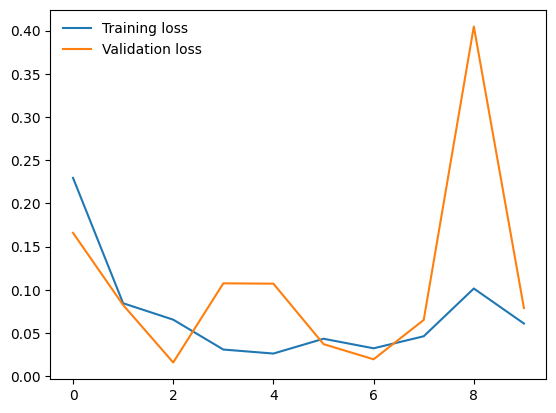

In [8]:
# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()


## Train final model

From the train and validation loss example, we decided to use 3 epochs of training. 

In [10]:
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training the model
num_epochs = 3
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()

    
    print(f"Epoch {epoch+1}/{num_epochs}.. "
          f"Train loss: {train_loss:.3f}.. ")
    
# Save the model
torch.save(model.state_dict(), f'../models/mobilenet_v2_final.pth')

Epoch 1/3.. Train loss: 0.031.. 
Epoch 2/3.. Train loss: 0.023.. 
Epoch 3/3.. Train loss: 0.019.. 
